<!-- BOB - 160 -->
<p align="center">
  <img src="https://imgur.com/PuZzq09.png" width="800">
</p>

In [5]:
# Core
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
    median_absolute_error, r2_score, explained_variance_score, root_mean_squared_error
)
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Boosting
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

# Statistics
from scipy.stats import pearsonr

In [6]:
df = pd.read_csv("../../Dataset/PVT_1225.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle rows

# Preview columns
print(df.columns.tolist())

# Define features and target
X = df.drop(columns=["Pb", "Bob"])
y = df["Pb"]

['Tf', 'Rs', 'gg', 'api', 'Pb', 'Bob']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 857
Testing samples: 368


# XGBoost

In [9]:
# Tuning XGBoost
param_grid = [
    {"n_estimators": n, "learning_rate": lr, "max_depth": d}
    for n in [100, 200]
    for lr in [0.01, 0.05, 0.1]
    for d in [4, 6, 8]
]

best_xgb_params, best_xgb_score = None, -float("inf")
best_xgb_mse = best_xgb_rmse = best_xgb_mae = best_xgb_r2 = best_xgb_adj_r2 = best_xgb_time = None

with tqdm(total=len(param_grid), desc="Tuning XGBoost") as pbar:
    for params in param_grid:
        start_time = time.time()
        xgb_model = XGBRegressor(**params, random_state=42)
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        end_time = time.time()

        # Metrics
        mse = mean_squared_error(y_test, y_pred_xgb)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred_xgb)
        r2 = r2_score(y_test, y_pred_xgb)
        elapsed = end_time - start_time

        # Adjusted R²
        n, p = len(y_test), X_test.shape[1]
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else None

        # Weighted Score (penalize RMSE, reward R²)
        score = -rmse + (r2 * 100)

        if score > best_xgb_score:
            best_xgb_params = params
            best_xgb_score = score
            best_xgb_mse = mse
            best_xgb_rmse = rmse
            best_xgb_mae = mae
            best_xgb_r2 = r2
            best_xgb_adj_r2 = adj_r2
            best_xgb_time = elapsed

        pbar.update(1)

# Print
print(f"\nBest XGBoost Params: {best_xgb_params}, Best Score: {best_xgb_score:.4f}, "
      f"Best MSE: {best_xgb_mse:.4f}, Best RMSE: {best_xgb_rmse:.4f}, Best MAE: {best_xgb_mae:.4f}, "
      f"Best R²: {best_xgb_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_xgb_adj_r2:.4f}' if best_xgb_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"XGBoost Training Time: {best_xgb_time:.4f}s")


Tuning XGBoost: 100%|███████████████████████████| 18/18 [00:01<00:00, 14.04it/s]


Best XGBoost Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 4}, Best Score: -236.4660, Best MSE: 108293.4906, Best RMSE: 329.0798, Best MAE: 178.8929, Best R²: 0.9261, Best Adjusted R²: 0.9253, XGBoost Training Time: 0.0342s


# CatBoost

In [11]:
# Tuning CatBoost
param_grid = [
    {"iterations": i, "learning_rate": lr, "depth": d, "l2_leaf_reg": reg}
    for i in [500, 1000]
    for lr in [0.01, 0.05, 0.1]
    for d in [4, 6]
    for reg in [3, 5, 7]
]

best_cat_params, best_cat_score = None, -float("inf")
best_cat_mse = best_cat_rmse = best_cat_mae = best_cat_r2 = best_cat_adj_r2 = best_cat_time = None

with tqdm(total=len(param_grid), desc="Tuning CatBoost") as pbar:
    for params in param_grid:
        start_time = time.time()
        cat_model = CatBoostRegressor(logging_level='Silent', random_state=42, **params)
        cat_model.fit(X_train, y_train)
        y_pred_cat = cat_model.predict(X_test)
        end_time = time.time()

        # Metrics
        mse = mean_squared_error(y_test, y_pred_cat)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred_cat)
        r2 = r2_score(y_test, y_pred_cat)
        elapsed = end_time - start_time

        # Adjusted R²
        n, p = len(y_test), X_test.shape[1]
        adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1)) if n > p + 1 else None

        # Weighted Score (penalize RMSE, reward R²)
        score = -rmse + (r2 * 100)

        if score > best_cat_score:
            best_cat_params = params
            best_cat_score = score
            best_cat_mse = mse
            best_cat_rmse = rmse
            best_cat_mae = mae
            best_cat_r2 = r2
            best_cat_adj_r2 = adj_r2
            best_cat_time = elapsed

        pbar.update(1)

# Print
print(f"\nBest CatBoost Params: {best_cat_params}, Best Score: {best_cat_score:.4f}, "
      f"Best MSE: {best_cat_mse:.4f}, Best RMSE: {best_cat_rmse:.4f}, Best MAE: {best_cat_mae:.4f}, "
      f"Best R²: {best_cat_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_cat_adj_r2:.4f}' if best_cat_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"CatBoost Training Time: {best_cat_time:.4f}s")


Tuning CatBoost: 100%|██████████████████████████| 36/36 [00:07<00:00,  5.01it/s]


Best CatBoost Params: {'iterations': 1000, 'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 7}, Best Score: -213.2137, Best MSE: 94122.5616, Best RMSE: 306.7940, Best MAE: 177.0382, Best R²: 0.9358, Best Adjusted R²: 0.9351, CatBoost Training Time: 0.1854s


# Neural Network

In [ ]:
#Standardized input for NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define grid
param_grid = [
    {"layers": [64, 32], "epochs": 100, "batch_size": 16},
    {"layers": [128, 64], "epochs": 100, "batch_size": 16},
    {"layers": [128, 64, 32], "epochs": 150, "batch_size": 32},
]

# Best tracking variables
best_nn_params, best_nn_score = None, -float("inf")
best_nn_mse = best_nn_rmse = best_nn_mae = best_nn_r2 = best_nn_adj_r2 = best_nn_time = None
best_nn_preds = None
best_nn_model = None

# Tuning loop
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

with tqdm(total=len(param_grid), desc="Tuning Neural Network") as pbar:
    for params in param_grid:

        def create_nn():
            model = Sequential()
            model.add(Input(shape=(X_train_scaled.shape[1],)))
            for units in params["layers"]:
                model.add(Dense(units, activation='relu'))
            model.add(Dense(1, activation='linear'))
            model.compile(optimizer=Adam(), loss='mse')
            return model

        start_time = time.time()
        nn_model = KerasRegressor(
            model=create_nn,
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )
        nn_model.fit(X_train_scaled, y_train)
        y_pred_nn = nn_model.predict(X_test_scaled)
        end_time = time.time()

        nn_mse = mean_squared_error(y_test, y_pred_nn)
        nn_rmse = np.sqrt(nn_mse)
        nn_mae = mean_absolute_error(y_test, y_pred_nn)
        nn_r2 = r2_score(y_test, y_pred_nn)
        nn_adj_r2 = 1 - ((1 - nn_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
        nn_score = -nn_rmse + (nn_r2 * 100)
        nn_time = end_time - start_time

        if nn_score > best_nn_score:
            best_nn_score = nn_score
            best_nn_params = params
            best_nn_model = nn_model
            best_nn_preds = y_pred_nn
            best_nn_mse = nn_mse
            best_nn_rmse = nn_rmse
            best_nn_mae = nn_mae
            best_nn_r2 = nn_r2
            best_nn_adj_r2 = nn_adj_r2
            best_nn_time = nn_time

        pbar.update(1)

# Print results
print(f"\nBest Neural Network Params: {best_nn_params}, Best Score: {best_nn_score:.4f}, Best MSE: {best_nn_mse:.4f}, "
      f"Best RMSE: {best_nn_rmse:.4f}, Best MAE: {best_nn_mae:.4f}, Best R²: {best_nn_r2:.4f}, "
      f"{f'Best Adjusted R²: {best_nn_adj_r2:.4f}' if best_nn_adj_r2 is not None else 'Best Adjusted R²: N/A'}, "
      f"Neural Net Training Time: {best_nn_time:.4f}s")


Tuning Neural Network:  33%|███████▎              | 1/3 [00:03<00:07,  3.87s/it]

# Stacking Ensemble

In [ ]:
# Define base learners with default/approximate params
base_estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('lasso', Lasso()),
    ('dt', DecisionTreeRegressor(max_depth=10)),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('svr', SVR()),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42))
]

# Define final estimator
final_estimator = CatBoostRegressor(verbose=0, random_state=42)

# Create the stacking model
stack = StackingRegressor(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=True
)

# Fit and evaluate
start_time = time.time()
with tqdm(total=1, desc="Training Stacked Model") as pbar:
    stack.fit(X_train, y_train)
    pbar.update(1)
stack_preds = stack.predict(X_test)
end_time = time.time()

# Calculate metrics
stack_mse = mean_squared_error(y_test, stack_preds)
stack_rmse = np.sqrt(stack_mse)
stack_mae = mean_absolute_error(y_test, stack_preds)
stack_r2 = r2_score(y_test, stack_preds)
n, p = len(y_test), X_test.shape[1]
stack_adj_r2 = 1 - ((1 - stack_r2) * (n - 1) / (n - p - 1))
stack_score = -stack_rmse + (stack_r2 * 100)
stack_time = end_time - start_time

# Print results
print(f"\nBest Stacked Ensemble Score: {stack_score:.4f}, Best MSE: {stack_mse:.4f}, "
      f"Best RMSE: {stack_rmse:.4f}, Best MAE: {stack_mae:.4f}, Best R²: {stack_r2:.4f}, "
      f"Best Adjusted R²: {stack_adj_r2:.4f}, Stacked Training Time: {stack_time:.4f}s")


# ExtraTreesRegressor

In [ ]:
# Start timing
start_time = time.time()

# Train ExtraTrees model with tqdm progress bar
with tqdm(total=1, desc="Training ExtraTrees") as pbar:
    et_model = ExtraTreesRegressor(n_estimators=200, random_state=42)
    et_model.fit(X_train, y_train)
    pbar.update(1)

# Predict
et_preds = et_model.predict(X_test)

# End timing
et_time = time.time() - start_time

# Evaluation Metrics
et_mse = mean_squared_error(y_test, et_preds)
et_rmse = np.sqrt(et_mse)
et_mae = mean_absolute_error(y_test, et_preds)
et_r2 = r2_score(y_test, et_preds)
et_adj_r2 = 1 - ((1 - et_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))

# Print results
print(f"Best ExtraTrees MSE: {et_mse:.4f}, RMSE: {et_rmse:.4f}, MAE: {et_mae:.4f}, "
      f"R²: {et_r2:.4f}, Adjusted R²: {et_adj_r2:.4f}, Training Time: {et_time:.4f}s")


# Deep Neural Network 

In [ ]:
#Standardized input for DNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define model builder
def create_deep_nn():
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear')) 
    model.compile(optimizer=Adam(), loss='mse')
    return model

# Grid for tuning
epoch_options = [100, 150]
batch_options = [16, 32]
param_grid = [(e, b) for e in epoch_options for b in batch_options]

best_dnn_score = -float("inf")
best_dnn_params = best_dnn_model = None
best_dnn_preds = None
best_dnn_mse = best_dnn_rmse = best_dnn_mae = best_dnn_r2 = best_dnn_adj_r2 = best_dnn_time = None

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

with tqdm(total=len(param_grid), desc="Tuning Deep NN") as pbar:
    for epochs, batch_size in param_grid:
        start_time = time.time()
        dnn_model = KerasRegressor(
            model=create_deep_nn,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )
        dnn_model.fit(X_train_scaled, y_train)
        dnn_preds = dnn_model.predict(X_test_scaled)
        end_time = time.time()

        dnn_mse = mean_squared_error(y_test, dnn_preds)
        dnn_rmse = np.sqrt(dnn_mse)
        dnn_mae = mean_absolute_error(y_test, dnn_preds)
        dnn_r2 = r2_score(y_test, dnn_preds)
        dnn_adj_r2 = 1 - ((1 - dnn_r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
        dnn_score = -dnn_rmse + (dnn_r2 * 100)
        dnn_time = end_time - start_time

        if dnn_score > best_dnn_score:
            best_dnn_score = dnn_score
            best_dnn_params = (epochs, batch_size)
            best_dnn_model = dnn_model
            best_dnn_preds = dnn_preds
            best_dnn_mse = dnn_mse
            best_dnn_rmse = dnn_rmse
            best_dnn_mae = dnn_mae
            best_dnn_r2 = dnn_r2
            best_dnn_adj_r2 = dnn_adj_r2
            best_dnn_time = dnn_time

        pbar.update(1)

# Print final results
print(f"\nBest Deep NN Params: epochs={best_dnn_params[0]}, batch_size={best_dnn_params[1]}, "
      f"Best Score: {best_dnn_score:.4f}, Best MSE: {best_dnn_mse:.4f}, Best RMSE: {best_dnn_rmse:.4f}, "
      f"Best MAE: {best_dnn_mae:.4f}, Best R²: {best_dnn_r2:.4f}, Best Adjusted R²: {best_dnn_adj_r2:.4f}, "
      f"Deep NN Training Time: {best_dnn_time:.4f}s")

# MSE, RMSE, MAE Comparisons

In [ ]:
x_labels = ["XGBoost", "CatBoost", "NN", "SE", "ETR", "DNN"]
mse_values = [best_xgb_mse, best_cat_mse, best_nn_mse, stack_mse, et_mse, best_dnn_mse]
mae_values = [best_xgb_mae, best_cat_mae, best_nn_mae, stack_mae, et_mae, best_dnn_mae]
rmse_values = [best_xgb_rmse, best_cat_rmse, best_nn_rmse, stack_rmse, et_rmse, best_dnn_rmse]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(x_labels, mse_values, color='violet')
axs[0].set_title("Comparison of MSE Across Models")
axs[0].set_ylabel("MSE Value")
axs[0].grid(axis='y')

axs[1].bar(x_labels, mae_values, color='pink')
axs[1].set_title("Comparison of MAE Across Models")
axs[1].set_ylabel("MAE Value")
axs[1].grid(axis='y')

axs[2].bar(x_labels, rmse_values, color='hotpink')
axs[2].set_title("Comparison of RMSE Across Models")
axs[2].set_ylabel("RMSE Value")
axs[2].grid(axis='y')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# R$^{2}$ & R$^{2}$ Adjusted  Comparisons

In [ ]:
#Graph R Squared Values

x_labels = ["XGBoost", "CatBoost", "NN" ,"SE", "ETR", "DNN"]

r2_values = [best_xgb_r2, best_cat_r2,best_nn_r2, stack_r2, et_r2, best_dnn_r2]
adjusted_r2_values = [val if val is not None else 0 for val in [best_xgb_adj_r2, best_cat_adj_r2, best_nn_adj_r2, stack_adj_r2, et_adj_r2, best_dnn_adj_r2]]

plt.style.use('default')

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot R² Scores
axs[0].bar(x_labels, r2_values, color='blue', alpha=0.6)
axs[0].set_title("Comparison of R² Scores Across Models")
axs[0].set_xlabel("Models")
axs[0].set_ylabel("R² Score")
axs[0].grid(axis='y')

# Plot Adjusted R² Scores
axs[1].bar(x_labels, adjusted_r2_values, color='orange', alpha=0.6)
axs[1].set_title("Comparison of Adjusted R² Scores Across Models")
axs[1].set_xlabel("Models")
axs[1].set_ylabel("Adjusted R² Score")
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
#Graph Scatter Plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
plot_index = 0  

def plot_actual_vs_predicted(y_test, y_pred, model_name, color):
    global plot_index  
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()

    # Compute correlation coefficient (Pearson's r)
    cc, _ = pearsonr(y_test, y_pred)

    # Plot on the current subplot
    ax = axes[plot_index]
    ax.scatter(y_test, y_pred, color=color, alpha=0.6, label=f"{model_name}")
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

    ax.text(0.03, 0.95, f"CC (r) = {cc:.4f}", transform=ax.transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # Labels and title
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{model_name}: Actual vs Predicted")
    ax.legend(loc='lower right')
    ax.grid(True)

    plot_index += 1  

plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost", "blue")
plot_actual_vs_predicted(y_test, y_pred_cat, "CatBoost", "green")
plot_actual_vs_predicted(y_test, y_pred_nn, "Neural Network", "purple")
plot_actual_vs_predicted(y_test, stack_preds, "Stacking Ensemble", "orange")
plot_actual_vs_predicted(y_test, et_preds, "Extra Trees Regressor", "cyan")
plot_actual_vs_predicted(y_test, dnn_preds, "Deep Neural Network", "magenta")

plt.tight_layout()
plt.show()

In [62]:
# Use best hyperparameters from earlier tuning
models = {
    "XGBoost": XGBRegressor(**best_xgb_params, random_state=42),
    "CatBoost": CatBoostRegressor(**best_cat_params, random_state=42, logging_level='Silent'),
    "Neural Network": best_nn_model,
    "Stacking Ensemble": stack,
    "Extra Trees Regressor": et_model,
    "Deep Neural Network": best_dnn_model
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    cv_scores = cross_validate(
        model, X, y.values.ravel(),
        scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
        cv=cv, return_train_score=False
    )
    
    rmse = np.sqrt(-cv_scores['test_neg_mean_squared_error'])
    mae = -cv_scores['test_neg_mean_absolute_error']
    r2 = cv_scores['test_r2']
    
    results.append({
        "Model": name,
        "RMSE Mean": rmse.mean(),
        "RMSE Std": rmse.std(),
        "MAE Mean": mae.mean(),
        "MAE Std": mae.std(),
        "R² Mean": r2.mean(),
        "R² Std": r2.std()
    })

# Create results table
cv_df = pd.DataFrame(results).sort_values(by="RMSE Mean")
pd.set_option('display.expand_frame_repr', False)
print("\n📊 5-Fold Cross-Validation Summary:")
print(cv_df)


📊 5-Fold Cross-Validation Summary:
                   Model   RMSE Mean   RMSE Std    MAE Mean    MAE Std   R² Mean    R² Std
4  Extra Trees Regressor  290.750365  33.519559  170.724103   9.566345  0.940732  0.013995
0                XGBoost  292.064531  53.056678  178.744762  18.818140  0.938876  0.021736
3      Stacking Ensemble  294.349449  49.304341  181.306852  15.465653  0.938060  0.020881
1               CatBoost  296.745771  42.848428  181.322312  17.429333  0.937966  0.016158
5    Deep Neural Network  496.947673  26.443658  358.732257  13.779518  0.829388  0.013165
2         Neural Network  499.334330  25.268946  362.251687  12.390151  0.827704  0.013162


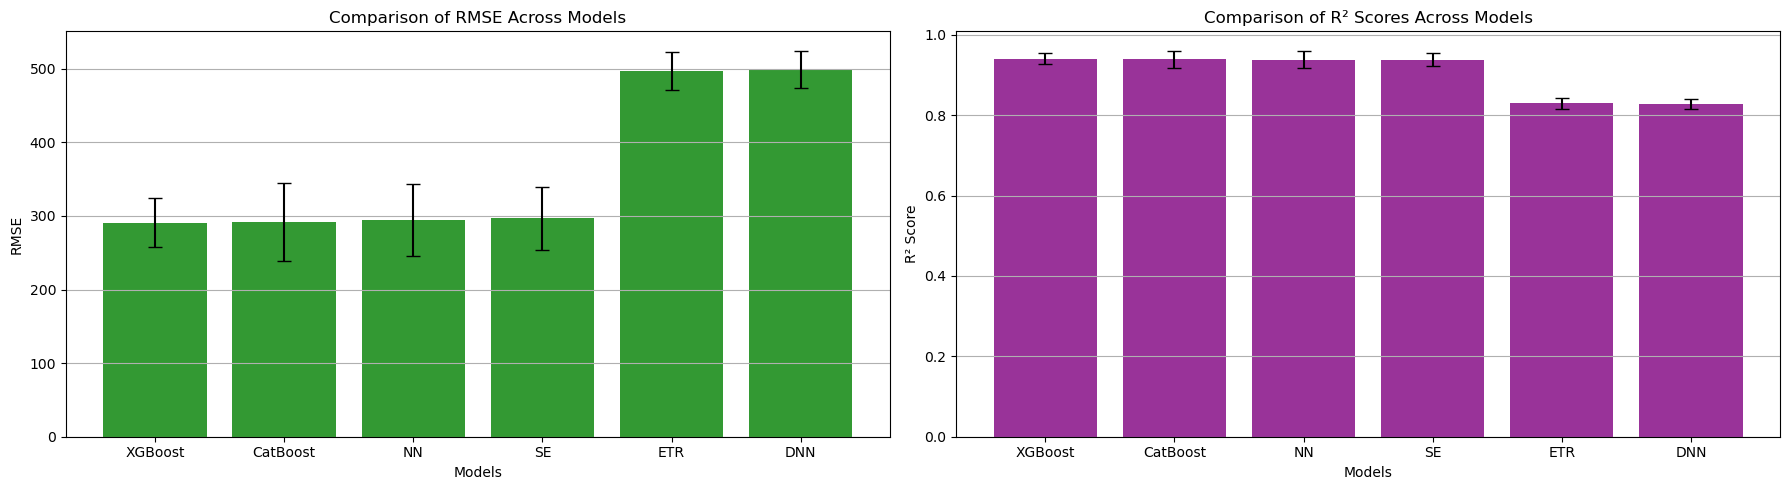

In [85]:
x_labels = ["XGBoost", "CatBoost", "NN", "SE", "ETR", "DNN"]

# Pull values from cv_df in the correct order
rmse_values = cv_df["RMSE Mean"].values
rmse_std = cv_df["RMSE Std"].values
r2_values = cv_df["R² Mean"].values
r2_std = cv_df["R² Std"].values

plt.style.use('default')
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot RMSE
axs[0].bar(x_labels, rmse_values, yerr=rmse_std, capsize=5, color='green', alpha=0.8)
axs[0].set_title("Comparison of RMSE Across Models")
axs[0].set_xlabel("Models")
axs[0].set_ylabel("RMSE")
axs[0].grid(axis='y')

# Plot R²
axs[1].bar(x_labels, r2_values, yerr=r2_std, capsize=5, color='purple', alpha=0.8)
axs[1].set_title("Comparison of R² Scores Across Models")
axs[1].set_xlabel("Models")
axs[1].set_ylabel("R² Score")
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

--------

# Checking Overfiting

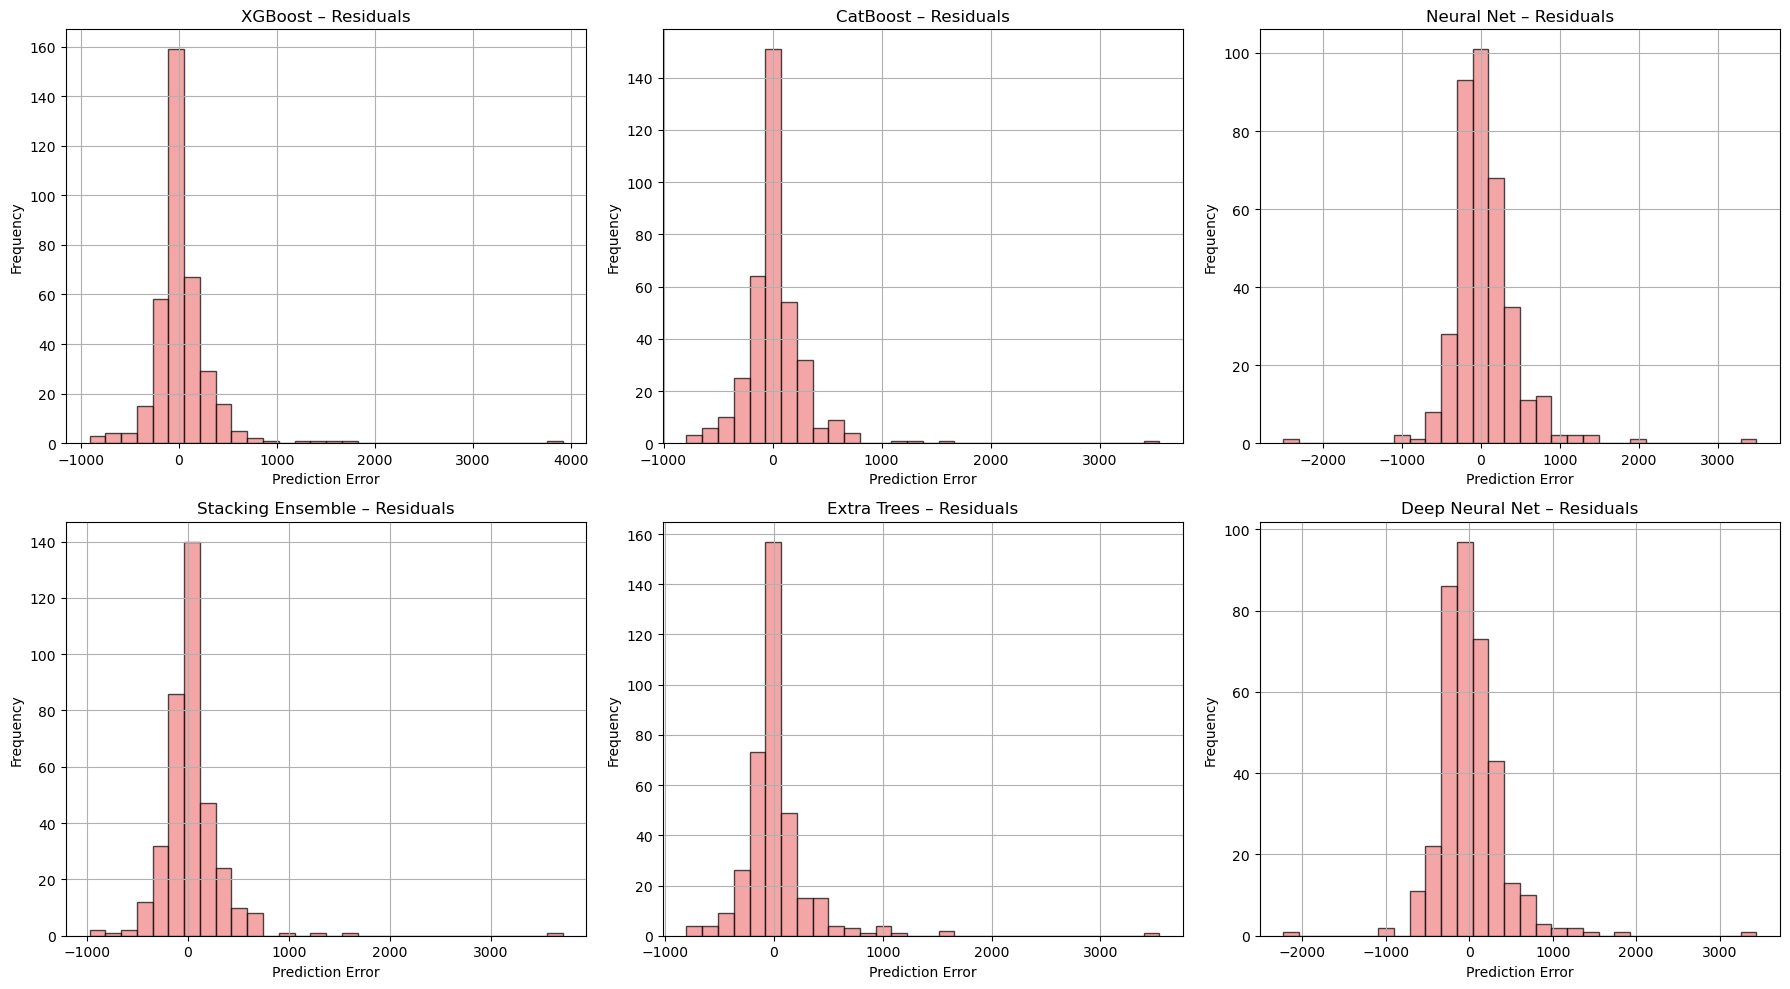

In [34]:
# Residuals
residuals = {
    "XGBoost": y_test - y_pred_xgb,
    "CatBoost": y_test - y_pred_cat,
    "Neural Net": y_test - best_nn_preds,
    "Stacking Ensemble": y_test - stack_preds,
    "Extra Trees": y_test - et_preds,
    "Deep Neural Net": y_test - dnn_preds
}

# Plot residual histograms
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (model, error) in enumerate(residuals.items()):
    ax = axes[idx]
    ax.hist(error, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    ax.set_title(f"{model} – Residuals")
    ax.set_xlabel("Prediction Error")
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.tight_layout()
plt.show()


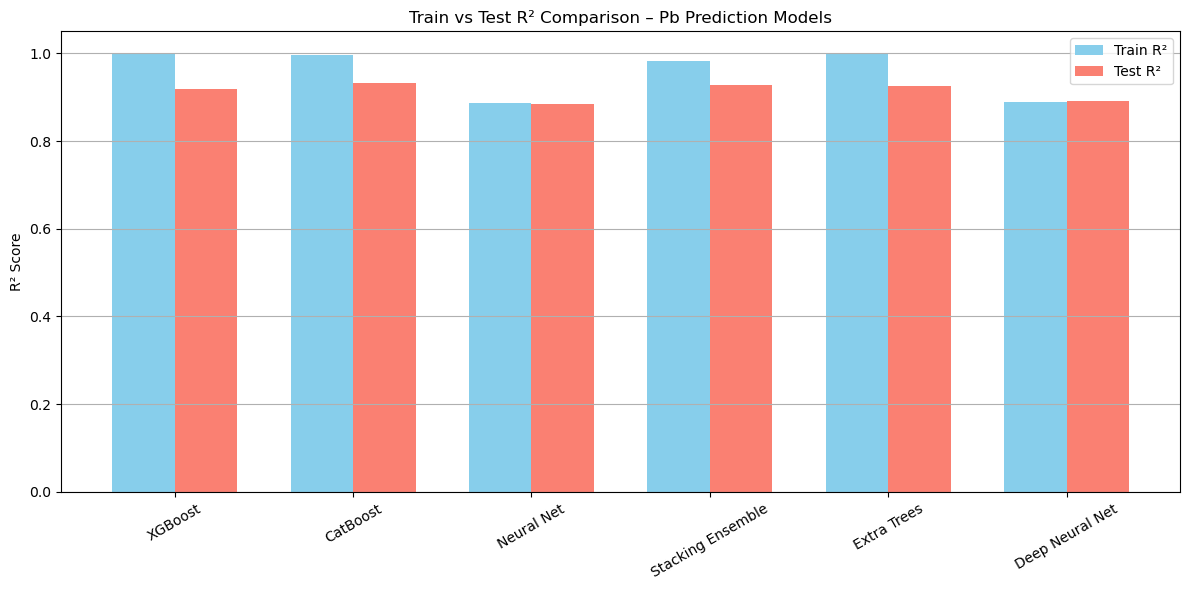

In [36]:
from sklearn.metrics import r2_score
import numpy as np

# Train predictions
train_preds = {
    "XGBoost": xgb_model.predict(X_train),
    "CatBoost": cat_model.predict(X_train),
    "Neural Net": best_nn_model.predict(X_train_scaled),
    "Stacking Ensemble": stack.predict(X_train),
    "Extra Trees": et_model.predict(X_train),
    "Deep Neural Net": best_dnn_model.predict(X_train_scaled),
}

# Test predictions
test_preds = {
    "XGBoost": y_pred_xgb,
    "CatBoost": y_pred_cat,
    "Neural Net": best_nn_preds,
    "Stacking Ensemble": stack_preds,
    "Extra Trees": et_preds,
    "Deep Neural Net": dnn_preds,
}

# R² scores
train_r2 = [r2_score(y_train, train_preds[model]) for model in train_preds]
test_r2 = [r2_score(y_test, test_preds[model]) for model in test_preds]

# Plot
x_labels = list(train_preds.keys())
x = np.arange(len(x_labels))

plt.figure(figsize=(12, 6))
bar_width = 0.35

plt.bar(x - bar_width/2, train_r2, width=bar_width, label='Train R²', color='skyblue')
plt.bar(x + bar_width/2, test_r2, width=bar_width, label='Test R²', color='salmon')

plt.xticks(x, x_labels, rotation=30)
plt.ylabel("R² Score")
plt.title("Train vs Test R² Comparison – Pb Prediction Models")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
